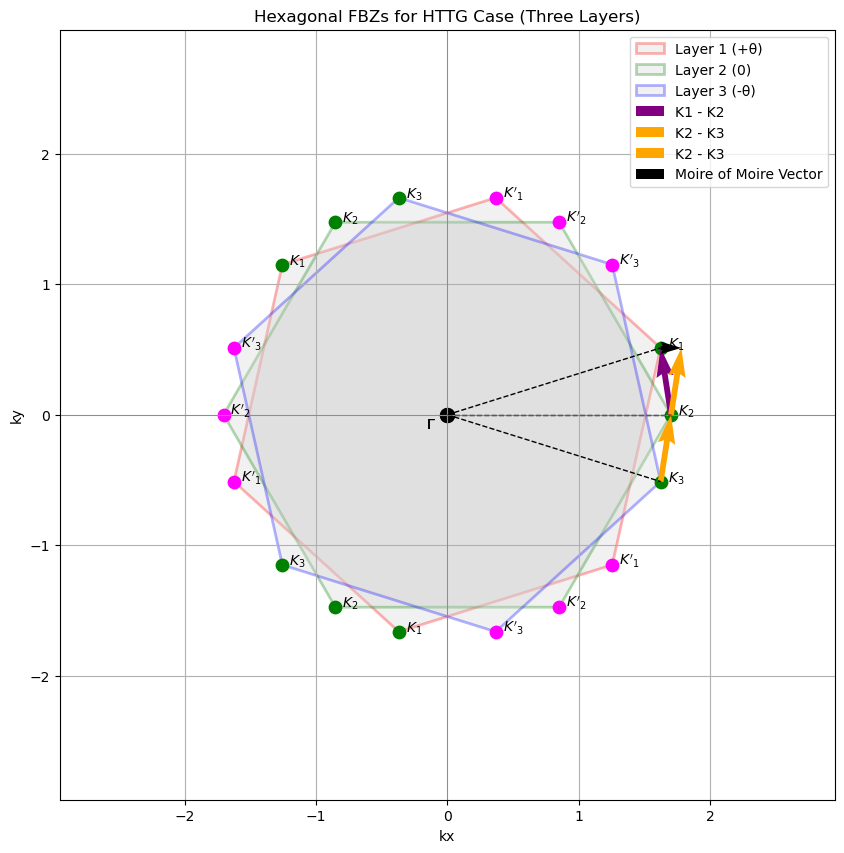

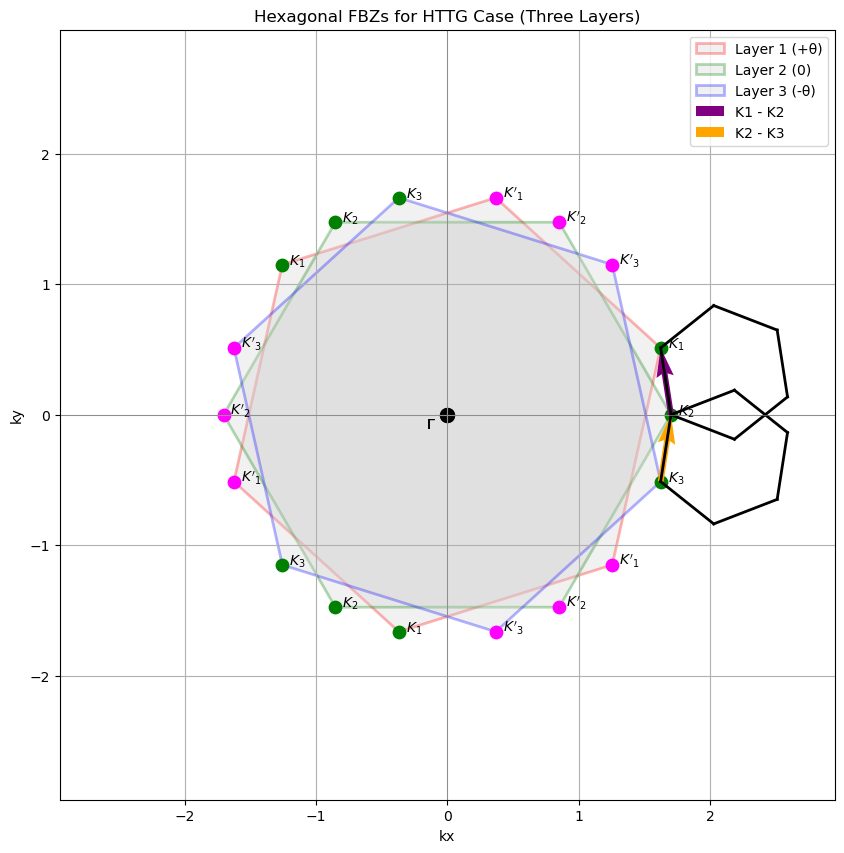

[0.03831726 0.02279637]
[ 0.03890087 -0.02178553]
[ 0.03948448 -0.06636744]
[-0.00058361  0.04458191]


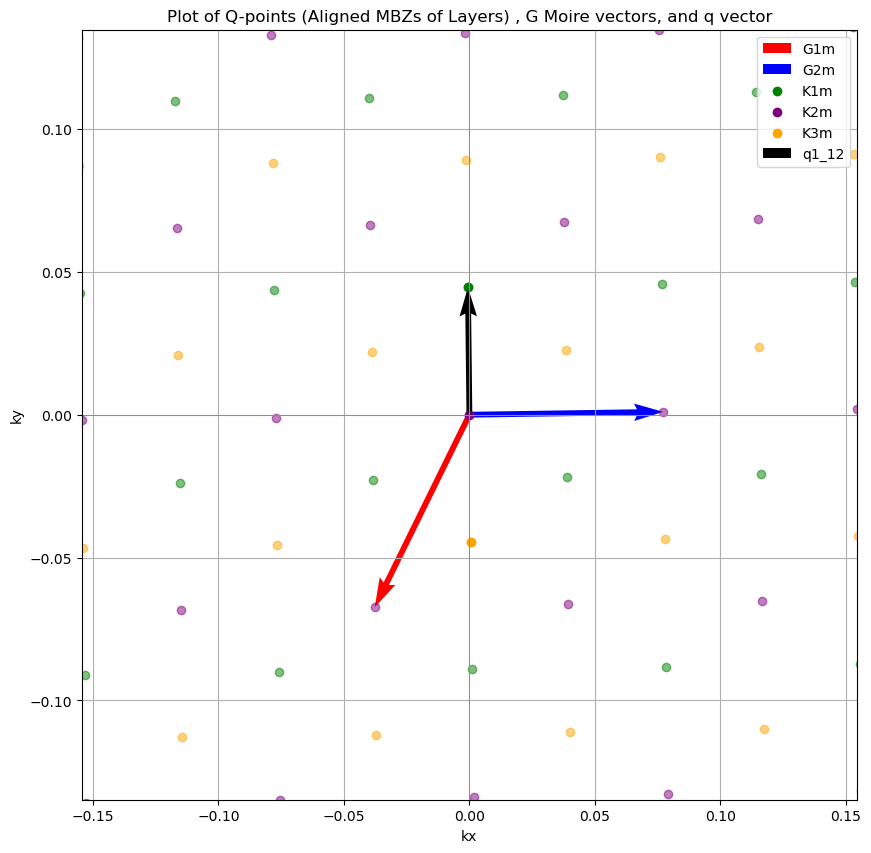

'for theta in theta_array:\n    calc_bands_HTTG(theta)'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull
from scipy.spatial.distance import cdist


""" PARAMETERS """
# Parameters
n_layers = 3
d = 1.42 # C-C Distance
a = np.sqrt(3)*d  # lattice constant
hv = 6582.12   # Fermi Velocity + Plank's Constant meV*angstrom

valley = 1  # valley index

npts = 100
N = 4  # truncate range of Q mbz grid about k points

w_ab = 105  # AB Tunneling Amplitudes
ratio = 0.00
w_aa = ratio * w_ab  # New w_aa based on ratio

# Define real-space lattice vectors
a1 = np.array([a, 0])
a2 = np.array([a / 2, a * np.sqrt(3) / 2])
real_space_lattice_vectors = [a1, a2]

# Pauli matrices
sigma_0 = np.array([[1, 0], [0, 1]], dtype=complex) # Identity
sigma_x = np.array([[0, 1], [1, 0]], dtype=complex) # Pauli X
sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex) # Pauli Y

# Function for rotation matrix
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])



def rotate_around_point(point, origin, angle_rad):
    translation = point - origin
    rotated_translation = np.dot(rotation_matrix(angle_rad), translation)
    return rotated_translation + origin


def kronecker_delta_momentum(q_diff, q_target):
    return np.all(np.abs(q_diff - q_target) < tolerance)

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def stacking_config(phi1, phi2, phi3):
    return np.array([phi1, phi2, phi3])

phi_ABA = stacking_config(0, 2 * np.pi / 3, -2 * np.pi / 3)
phi_AAA = stacking_config(0,0,0)

# Calculate reciprocal lattice vectors between layers 1 and 2
reciprocal_vectors = get_reciprocal_lattice_vectors(real_space_lattice_vectors)
b1, b2 = reciprocal_vectors    

# Define tunneling matrix using Pauli matrices
def tunneling_matrix(w_aa, w_ab, c3_angle,phi):
    return (w_aa * sigma_0 + w_ab * ( (np.cos(c3_angle) * sigma_x + np.sin(c3_angle) * sigma_y)* np.exp(-1j * phi) ) )

# Construction of the relevant Tunneling matrices # phi = lattice relaxation const to control/modulate the stacking configuration
T1_12 = tunneling_matrix(w_aa, w_ab, 0, phi_AAA[0])
T2_12 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3, phi_AAA[1])
T3_12 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3, phi_AAA[2])

T1_23 = tunneling_matrix(w_aa, w_ab, 0, -phi_ABA[0])
T2_23 = tunneling_matrix(w_aa, w_ab, 2 * np.pi / 3, -phi_AAA[1])
T3_23 = tunneling_matrix(w_aa, w_ab, -2 * np.pi / 3, -phi_AAA[2])

# Generate moiré lattice vectors
siteN = (2 * N + 1) ** 2
L = np.zeros((siteN, 2))
k = 0
for i in np.arange(2 * N + 1):
    for j in np.arange(2 * N + 1):
        L[k, 0] = i - N
        L[k, 1] = j - N
        k += 1

def klines(A, B, numpts):
    return np.array([np.linspace(A[jj], B[jj], numpts) for jj in range(len(A))]).T

# Function to create the special k-path for TBG
def moire_kline(npts, delk):
    # Define the Moiré Brillouin zone endpoints
    K1 = delk * np.array([0, 0])
    kappa = delk * np.array([np.sqrt(3)/2, -1/2])
    kappa_prime = delk  * np.array([np.sqrt(3)/2, 1/2])
    K1 = delk * np.array([0, 0])
    m = delk * np.array([np.sqrt(3)/2, 0])

    
    # Generate the k-path segments
    kline1 = klines(K1, kappa, npts)
    kline2 = klines(kappa, kappa_prime , npts)
    kline3 = klines(kappa_prime , K1, npts)
    kline4 = klines(K1, m , npts)
    
    
    # Labels for each segment
    klabels = [r'$K_1$', r'$\kappa$', r'$\kappa^{\prime}$', r'M', r'$K_1$']
    kcoord = np.array([0, (npts - 1), 2 * (npts - 1), 3 * (npts - 1),4 * (npts - 1)])
    
    # Concatenate the path segments
    return np.concatenate((kline1[:-1, :], kline2[:-1, :], kline3[:-1, :],kline4[:-1, :])), kcoord, klabels

def Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m):
    # Initialize Hamiltonian
    H = np.zeros((6 * siteN, 6 * siteN), dtype=complex)

    # Loop through each lattice position to calculate q1, q2 and assign to Hamiltonian
    for i in range(siteN):
        n1 = L[i, 0]
        n2 = L[i, 1]
        
        # Compute q1 and q2 as arrays with x and y components
        q1 = np.array([kx, ky]) - K1m + n1 * G1m + n2 * G2m
        q2 = np.array([kx, ky]) - K2m + n1 * G1m + n2 * G2m
        q3 = np.array([kx, ky]) - K3m + n1 * G1m + n2 * G2m

        # Assign intralayer terms for each layer
        H[2*i:2*i+2, 2*i:2*i+2] = -hv * (valley * q1[0] * sigma_x + q1[1] * sigma_y)
        H[2*i+2*siteN:2*i+2*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = -hv * (valley * q2[0] * sigma_x + q2[1] * sigma_y)
        H[2*i+4*siteN:2*i+4*siteN+2, 2*i+4*siteN:2*i+4*siteN+2] = -hv * (valley * q3[0] * sigma_x + q3[1] * sigma_y)
        # Loop over other sites for interlayer coupling
        for j in range(siteN):
            m1 = L[j, 0]
            m2 = L[j, 1]

            # Set Kronecker delta values based on index shifts
            kd_0 = int((m1 == n1) and (m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((m1 == n1 - valley) and (m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((m1 == n1 - valley) and (m2 == n2 - valley))  # Checks if delta_q = q3

            # Combine tunneling matrices based on Kronecker delta values
            T_12 = kd_0 * T1_12 + kd_G1 * T2_12 + kd_G1G2 * T3_12

            kd_0 = int((-m1 == n1) and (-m2 == n2))  # Checks if delta_q = q1
            kd_G1 = int((-m1 == n1 - valley) and (-m2 == n2))  # Checks if delta_q = q2
            kd_G1G2 = int((-m1 == n1 - valley) and (-m2 == n2 - valley))  # Checks if delta_q = q3

            
            T_23 = kd_0 * T1_23 + kd_G1 * T2_23 + kd_G1G2 * T3_23

            # Block assign the tunneling matrix T to the Hamiltonian
            H[2*i:2*i+2, 2*j+2*siteN:2*j+2*siteN+2] = T_12.conjugate().T
            H[2*j+2*siteN:2*j+2*siteN+2, 2*i:2*i+2] = T_12
            
            H[2*i+2*siteN:2*i+2*siteN+2, 2*j+4*siteN:2*j+4*siteN+2] = T_23.conjugate().T
            H[2*j+4*siteN:2*j+4*siteN+2, 2*i+2*siteN:2*i+2*siteN+2] = T_23
            
    
    # Calculate and return sorted eigenvalues
    eigenvalues = np.linalg.eigvalsh(H)  # Use eigvalsh for Hermitian matrix eigenvalues
    return np.sort(eigenvalues)


def calc_bands_HTTG(theta_deg):
    # Convert theta to radians and recalculate delk for the new theta
    theta_rad = np.radians(theta_deg)
    theta_values = [theta_rad, 0.0, -theta_rad]
    delk = 8 * np.pi * np.sin(theta_rad / 2) / (a * 3)  # Moire Modulated reciprocal spacing constant for the mBZ
    
    # Recalculate rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Recalculate mBZ vectors G1m and G2m for the given theta
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # Recalculate K-point values and q vectors for the given theta
    K1m = (1/3) * G1m + (2/3) * G2m
    K2m = -(1/3) * G1m - (2/3) * G2m
    K2m = np.dot(rotation_matrix(-2 * np.pi / 3), K2m)
    q1_12 = K2m - K1m
    q2_12 = np.dot(rotation_matrix(2 * np.pi / 3), q1_12)
    q3_12 = np.dot(rotation_matrix(4 * np.pi / 3), q1_12)
    K3m = K1m + q1_12

    # Shifting all K-points such that K1m is at (0, 0)
    K1m = K1m - K1m  # This will be [0, 0]
    K3m = K1m - q1_12
    K2m = K1m + q1_12


    # Call the function to plot the band structure for the current theta
    plot_band_structure(Hamiltonian, npts, delk, theta_deg, K1m, K2m, K3m, G1m, G2m)


        

def plot_band_structure(Hamiltonian, npts, delk, theta_deg,K1m, K2m, K3m, G1m, G2m):
    k_path, kcoord, klabels = moire_kline(npts, delk)
    num_bands = 6 * siteN  # Adjust based on Hamiltonian size for TBG
    E = np.zeros((len(k_path), num_bands))
    
    # Evaluate Hamiltonian eigenvalues at each k-point along the path
    for idx, k_point in enumerate(k_path):
        kx, ky = k_point  # Extract kx and ky from the path point
        E[idx, :] = Hamiltonian(kx, ky, K1m, K2m, K3m, G1m, G2m)  # Directly store sorted eigenvalues

    # Plotting the band structure
    plt.figure(figsize=(8, 6))
    for i in range(num_bands):
        plt.plot(E[:, i], lw=0.6)
   
    # Customize plot
    plt.xticks(kcoord, klabels)  # Set tick positions and labels
    plt.xlabel("k-path")
    plt.ylabel("Energy (meV)")
    for xc in kcoord:
        plt.axvline(x=xc, color='gray', linestyle='--', linewidth=0.5)
    plt.title(f"Continuum Model - Tight Binding TBG - Band Structure (theta = {theta_deg} degrees)")
    plt.ylim(-150, 150)
    plt.show()

def plot_fbz_layer(ax, b, theta, color, layer_label, layer_index):
    # Rotate the reciprocal lattice vectors
    b_rotated = np.dot(b, rotation_matrix(theta).T)

    # Generate lattice points around the origin
    N = 1  # Number of neighboring points to include
    reciprocal_lattice_points = []
    b1, b2 = b_rotated[0], b_rotated[1]
    for n in range(-N, N + 1):
        for m in range(-N, N + 1):
            point = n * b1 + m * b2
            reciprocal_lattice_points.append(point)
    reciprocal_lattice_points = np.array(reciprocal_lattice_points)

    # Create Voronoi diagram to find FBZ
    vor = Voronoi(reciprocal_lattice_points)

    # Identify region corresponding to the origin (Gamma point)
    center_indices = np.where(np.all(np.isclose(reciprocal_lattice_points, [0, 0], atol=1e-8), axis=1))[0]
    center_index = center_indices[0]
    center_region_index = vor.point_region[center_index]
    center_region = vor.regions[center_region_index]

    # Get vertices of the FBZ
    vertices = vor.vertices[center_region]

    # Order vertices counter-clockwise
    hull = ConvexHull(vertices)
    vertices = vertices[hull.vertices]

    # High-symmetry points
    Gamma = np.array([0, 0])
    K_point = (2 * b_rotated[0] + b_rotated[1]) / 3
    K_prime_point = -K_point  # Inversion through Gamma point

    # Identify K and K' points among vertices
    K_vertices = []
    K_prime_vertices = []
    for vertex in vertices:
        matched = False
        for n in [-1, 0, 1]:
            for m in [-1, 0, 1]:
                shift = n * b_rotated[0] + m * b_rotated[1]
                if np.allclose(vertex, K_point + shift, atol=1e-8):
                    K_vertices.append(vertex)
                    matched = True
                    break
                elif np.allclose(vertex, K_prime_point + shift, atol=1e-8):
                    K_prime_vertices.append(vertex)
                    matched = True
                    break
            if matched:
                break

    # Plot FBZ vertices, closed=True, facecolor='lightgray', 
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor=color, alpha = 0.3, linewidth=2, label=layer_label)
    ax.add_patch(polygon)

    # Plot high-symmetry points
    ax.scatter(Gamma[0], Gamma[1], color='black', s=100)
    ax.annotate('$\\Gamma$', xy=(Gamma[0], Gamma[1]), xytext=(-15, -10), textcoords='offset points')
    for K in K_vertices:
        ax.scatter(K[0], K[1], color='green', s=80)
        ax.annotate(f'$K_{{{layer_index}}}$', xy=(K[0], K[1]), xytext=(5, 0), textcoords='offset points')

    # Plot K' points with the correct layer label (e.g., K'_1, K'_2, K'_3)
    for K_prime in K_prime_vertices:
        ax.scatter(K_prime[0], K_prime[1], color='magenta', s=80)
        ax.annotate(f"$K'_{{{layer_index}}}$", xy=(K_prime[0], K_prime[1]), xytext=(5, 0), textcoords='offset points')

    return K_vertices, K_prime_vertices



def plot_geometry(theta):
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    d = a0 * np.sqrt(3)
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Rotation angles for the three layers
    theta_values = [np.radians(theta), 0.0, -np.radians(theta)]
    colors = ['red', 'green', 'blue']
    labels = ['Layer 1 (+θ)', 'Layer 2 (0)', 'Layer 3 (-θ)']

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 10))

    K_positions = []  # List to store K-point positions for each layer

    for i, theta_val in enumerate(theta_values):
        K_vertices, K_prime_vertices = plot_fbz_layer(ax, b, theta_val, colors[i], labels[i], int(i + 1))
        
        # Store the first K point if available
        if K_vertices:
            if i == 0:
                # Assign the first K point for the first layer
                K_positions.append(K_vertices[1])
            elif i == 1:
                # Assign a specific K point for the second layer (e.g., the second K point)
                K_positions.append(K_vertices[1] if len(K_vertices) > 1 else K_vertices[0])
            elif i == 2:
                # Assign a different K point for the third layer (e.g., the last K point or a specific index)
                K_positions.append(K_vertices[0] if len(K_vertices) > 2 else K_vertices[0])

    Gamma = np.array([0, 0])  # The origin point (Gamma)
    for K in K_positions:
        ax.plot([Gamma[0], K[0]], [Gamma[1], K[1]], 'k--', linewidth=1)  # Dashed line

    # Check if there are enough K positions to calculate differences
    if len(K_positions) >= 3:
        K1 = K_positions[0]
        K2 = K_positions[1]
        K3 = K_positions[2]

        # Calculate K2 - K1 and K3 - K2
        K1_minus_K2 = K1 - K2
        K2_minus_K3 = K2 - K3
        infq = K2_minus_K3 - K1_minus_K2 

        # Plot K1 - K2 vector
        ax.quiver(K2[0], K2[1], K1_minus_K2[0], K1_minus_K2[1], angles='xy', scale_units='xy', scale=1, color='purple', label='K1 - K2')

        # Plot K2 - K3 vector
        ax.quiver(K2[0], K2[1], K2_minus_K3[0], K2_minus_K3[1], angles='xy', scale_units='xy', scale=1, color='orange', label='K2 - K3')
        ax.quiver(K3[0], K3[1], K2_minus_K3[0], K2_minus_K3[1], angles='xy', scale_units='xy', scale=1, color='orange', label='K2 - K3')
        ax.quiver(K1[0], K1[1], infq[0], infq[1], angles='xy', scale_units='xy', scale=1, color='black', label='Moire of Moire Vector')

    # Customize the plot
    ax.set_xlim(-1 * np.max(np.abs(b)), 1 * np.max(np.abs(b)))
    ax.set_ylim(-1 * np.max(np.abs(b)), 1 * np.max(np.abs(b)))
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_title('Hexagonal FBZs for HTTG Case (Three Layers)')
    ax.legend()
    ax.grid(True)
    plt.show()

def plot_geometry1(theta):
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    d = a0 * np.sqrt(3)
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Rotation angles for the three layers
    theta_values = [np.radians(theta), 0.0, -np.radians(theta)]
    colors = ['red', 'green', 'blue']
    labels = ['Layer 1 (+θ)', 'Layer 2 (0)', 'Layer 3 (-θ)']

    # Plot setup
    fig, ax = plt.subplots(figsize=(10, 10))

    K_positions = []  # List to store K-point positions for each layer

    for i, theta_val in enumerate(theta_values):
        K_vertices, K_prime_vertices = plot_fbz_layer(ax, b, theta_val, colors[i], labels[i], int(i + 1))
        
        # Store the first K point if available
        if K_vertices:
            if i == 0:
                # Assign the first K point for the first layer
                K_positions.append(K_vertices[1])
            elif i == 1:
                # Assign a specific K point for the second layer (e.g., the second K point)
                K_positions.append(K_vertices[1] if len(K_vertices) > 1 else K_vertices[0])
            elif i == 2:
                # Assign a different K point for the third layer (e.g., the last K point or a specific index)
                K_positions.append(K_vertices[0] if len(K_vertices) > 2 else K_vertices[0])

    
    # Check if there are enough K positions to calculate differences
    if len(K_positions) >= 3:
        K1 = K_positions[0]
        K2 = K_positions[1]
        K3 = K_positions[2]

        # Plot black lines between K1 and K2, and K2 and K3
        ax.plot([K1[0], K2[0]], [K1[1], K2[1]], 'k-', linewidth=2)
        ax.plot([K2[0], K3[0]], [K2[1], K3[1]], 'k-', linewidth=2)
    
        current_K1 = K1
        current_K2 = K2

        for i in range(5):
            next_K1 = rotate_around_point(current_K2, current_K1, np.radians(120))
            next_K2 = rotate_around_point(current_K1, current_K1, np.radians(120))

            ax.plot([next_K1[0], next_K2[0]], [next_K1[1], next_K2[1]], 'k-', lw=2 )   

            # Update for next iteration
            current_K1 = next_K1
            current_K2 = next_K2

        current_K2 = K2
        current_K3 = K3

        for i in range(5): 
            next_K2 = rotate_around_point(current_K3, current_K2, np.radians(120))
            next_K3 = rotate_around_point(current_K2, current_K2, np.radians(120))

            ax.plot([next_K2[0], next_K3[0]], [next_K2[1], next_K3[1]], 'k-', lw=2 )   

            # Update for next iteration
            current_K2 = next_K2
            current_K3 = next_K3


        

        # Calculate K2 - K1 and K3 - K2
        K1_minus_K2 = K1 - K2
        K2_minus_K3 = K2 - K3

        # Plot K1 - K2 vector
        ax.quiver(K2[0], K2[1], K1_minus_K2[0], K1_minus_K2[1], angles='xy', scale_units='xy', scale=1, color='purple', label='K1 - K2')

        # Plot K2 - K3 vector
        ax.quiver(K3[0], K3[1], K2_minus_K3[0], K2_minus_K3[1], angles='xy', scale_units='xy', scale=1, color='orange', label='K2 - K3')

    # Customize the plot
    ax.set_xlim(-1 * np.max(np.abs(b)), 1 * np.max(np.abs(b)))
    ax.set_ylim(-1 * np.max(np.abs(b)), 1 * np.max(np.abs(b)))
    ax.axhline(0, color='gray', linewidth=0.5)
    ax.axvline(0, color='gray', linewidth=0.5)
    ax.set_xlabel('kx')
    ax.set_ylabel('ky')
    ax.set_title('Hexagonal FBZs for HTTG Case (Three Layers)')
    ax.legend()
    ax.grid(True)
    plt.show()    

def plot_geometry2(theta):    
    a0 = 1.42
    d = a0 * np.sqrt(3)
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    b = get_reciprocal_lattice_vectors(a)
    theta_values = [np.radians(theta), 0.0, -np.radians(theta)]
    
    # Apply rotation to calculate the rotated reciprocal lattice vectors
    b1_rot = np.dot(rotation_matrix(theta_values[0]), b1)
    b2_rot = np.dot(rotation_matrix(theta_values[0]), b2)

    # Calculate mBZ vectors G1m and G2m for layers 1 and 2
    G1m = b1 - b1_rot  # Replacement for G1
    G2m = b2 - b2_rot  # Replacement for G2

    # mBZ K-point values
    K2m = (1/3) * G1m + (2/3) * G2m
    K1m = -(1/3) * G1m - (2/3) * G2m
    K1m = np.dot(rotation_matrix(-2 * np.pi / 3), K1m)
    q1_12 = K1m - K2m
    K3m = K2m - q1_12 

    print(K1m)
    print(K2m)
    print(K3m)
    print(q1_12)

    # Shifting all K-points such that K1m is at (0, 0)
    K2m = K2m - K2m  # This will be [0, 0]
    K3m = K2m - q1_12
    K1m = K2m + q1_12



    # Plot vectors
    plt.figure(figsize=(10, 10))
    origin = np.array([0, 0])

    # Plot G1m and G2m
    plt.quiver(*origin, *G1m, color='r', scale=1, scale_units='xy', angles='xy', label='G1m')
    plt.quiver(*origin, *G2m, color='b', scale=1, scale_units='xy', angles='xy', label='G2m')

    # Plot K-points
    plt.scatter(*K1m, color='g', label='K1m')
    plt.scatter(*K2m, color='purple', label='K2m')
    plt.scatter(*K3m, color='orange', label='K3m')
    #plt.scatter(*K4m, color='orange', label='K4m')

    # Plot q1_12
    plt.quiver(*K2m, *q1_12, color='black', scale=1, scale_units='xy', angles='xy', label='q1_12')


    num_translations = 3  # Number of integer translations in each direction
    for n in range(-num_translations, num_translations + 1):
        for m in range(-num_translations, num_translations + 1):
            # Calculate translated K-points
            K1m_translated = K1m + n * G1m + m * G2m
            K2m_translated = K2m + n * G1m + m * G2m
            K3m_translated = K3m + n * G1m + m * G2m
            
            # Plot translated K-points
            plt.scatter(*K1m_translated, color='g', alpha=0.5)
            plt.scatter(*K2m_translated, color='purple', alpha=0.5)
            plt.scatter(*K3m_translated, color='orange', alpha=0.5)

    # Customize plot to center at (0, 0) and set expanded limits
    plt.xlim(-2 * max(abs(G1m[0]), abs(G2m[0])), 2 * max(abs(G1m[0]), abs(G2m[0])))
    plt.ylim(-2 * max(abs(G1m[1]), abs(G2m[1])), 2 * max(abs(G1m[1]), abs(G2m[1])))
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.title('Plot of Q-points (Aligned MBZs of Layers) , G Moire vectors, and q vector')
    plt.legend()
    plt.grid(True)
    plt.show()   
    

#plot_geometry()

theta_array = [5.0,3.0,2.5,2.0,1.8,1.75,1.70,1.65,1.6,1.55,1.5,1.45,1.2,0.8,0.75,0.7,0.65]

plot_geometry(17.5)

plot_geometry1(17.5)

plot_geometry2(1.5)

"""for theta in theta_array:
    calc_bands_HTTG(theta)"""


